In [1]:
import sys
sys.path.append("../../")

from astronn.preprocess import predeltascuti, precorot
from astronn.datasets import deltascuti, starmodels, corot
from astronn import models

import tensorflow as tf
import numpy as np
import shap

import matplotlib.pyplot as plt
from pygam import LinearGAM
from collections import Counter

Using TensorFlow backend.


#### Preprocess is not needed if data exists in beforehand

In [2]:
# Preprocess eleven delta scuti stars
if False:
    # Preprocess DS stars
    preprocessor = predeltascuti()
    preprocessor.preprocess_files(
        input_folder="../../astronn/data/deltascuti/raw/*",
        output_folder="../../astronn/data/deltascuti/preprocessed/",
    )

# Preprocess 77 CoRoT stars
if False:
    preprocessor = precorot(conf_file="../../astronn/data/corot/parameters.csv", cols=["corot", "loggs"])
    preprocessor.preprocess_files(
        input_folder="../../astronn/data/corot/raw/*",
        output_folder="../../astronn/data/corot/preprocessed/",
    )

#### Utils functions

In [3]:
def normalize(x):
    """
    """
    return (x - np.min(x)) / (np.max(x) - np.min(x))

# Custom metrics
def top_2_categorical_accuracy(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=2)

def top_4_categorical_accuracy(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=4)

def top_6_categorical_accuracy(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=6)

def top_8_categorical_accuracy(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=8)

def calculate_shap_by_gradient(model, x_explain):
    """
    """
    e = shap.GradientExplainer(model, x_train, batch_size=1000, local_smoothing=0)
    shap_values, indexes = e.shap_values(x_explain, nsamples=10000, ranked_outputs=5)
    return shap_values, indexes

In [4]:
# Load best model (old train method)
sepconv_mod = tf.keras.models.load_model(
    "/home/roberto/Projects/asteroseismologyNN/models/model_dnu_noisy.h5",
    custom_objects={"rec_at_2": top_2_categorical_accuracy,
                    "rec_at_4": top_4_categorical_accuracy,
                    "recat_6": top_6_categorical_accuracy,
                    "rec_at_8": top_8_categorical_accuracy}
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


#### Process 11 ds stars, infer Dnu and calculate shap values explanations

ed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: Bad argument number for Name: 3, expecting 4
[[52 51 49 50 48 54 53 47 55 56]]
[[36 37 35 34 38 33 39 32 20 23]]
[[38 22 37 40 41 31 28 29 36 27]]


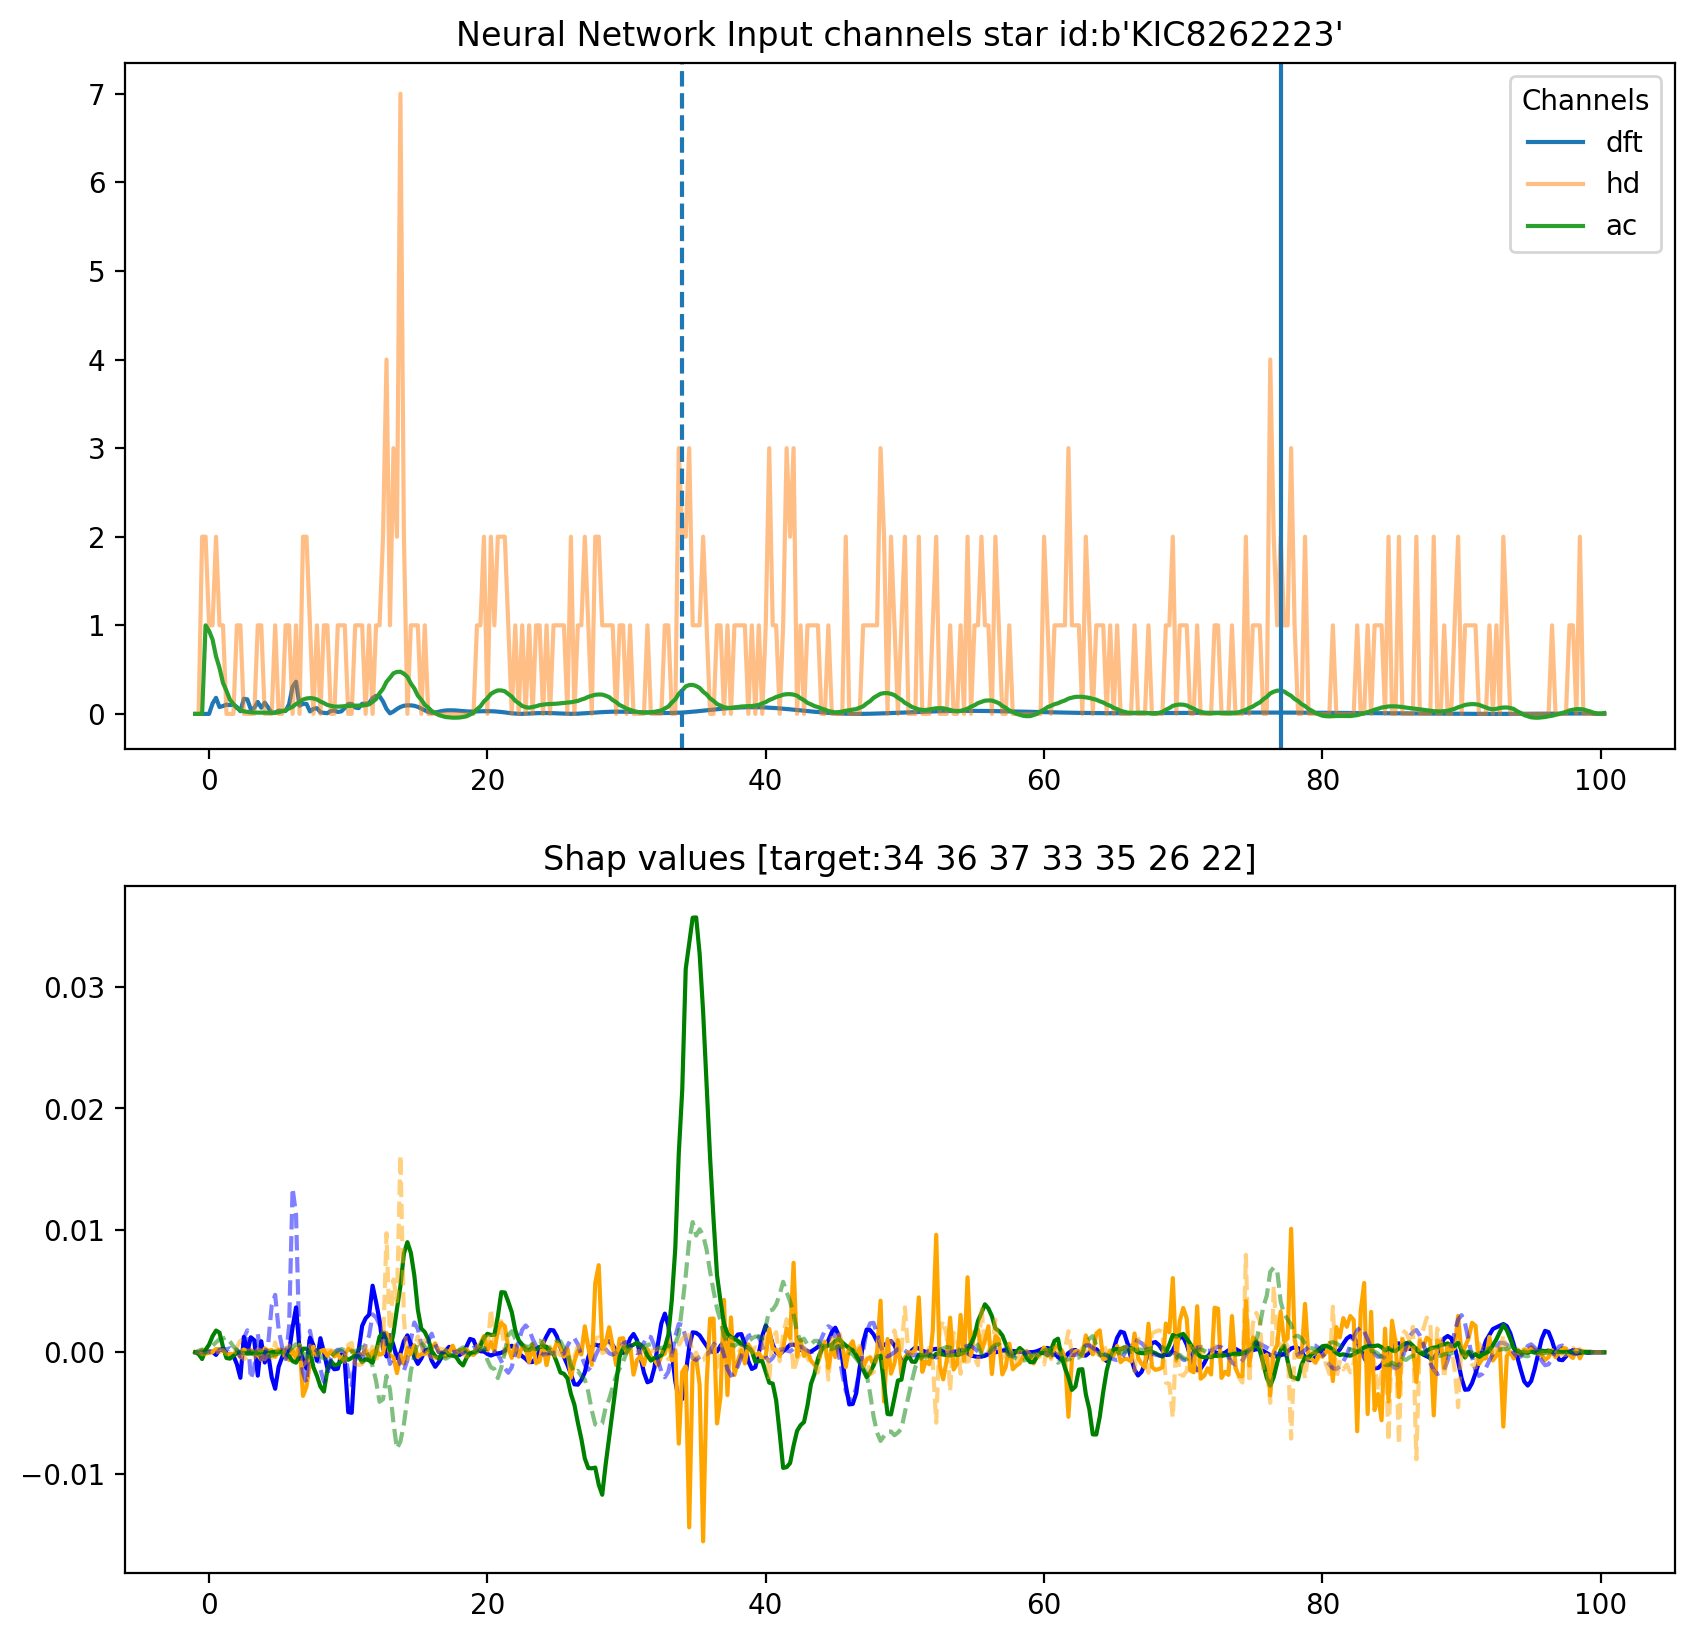

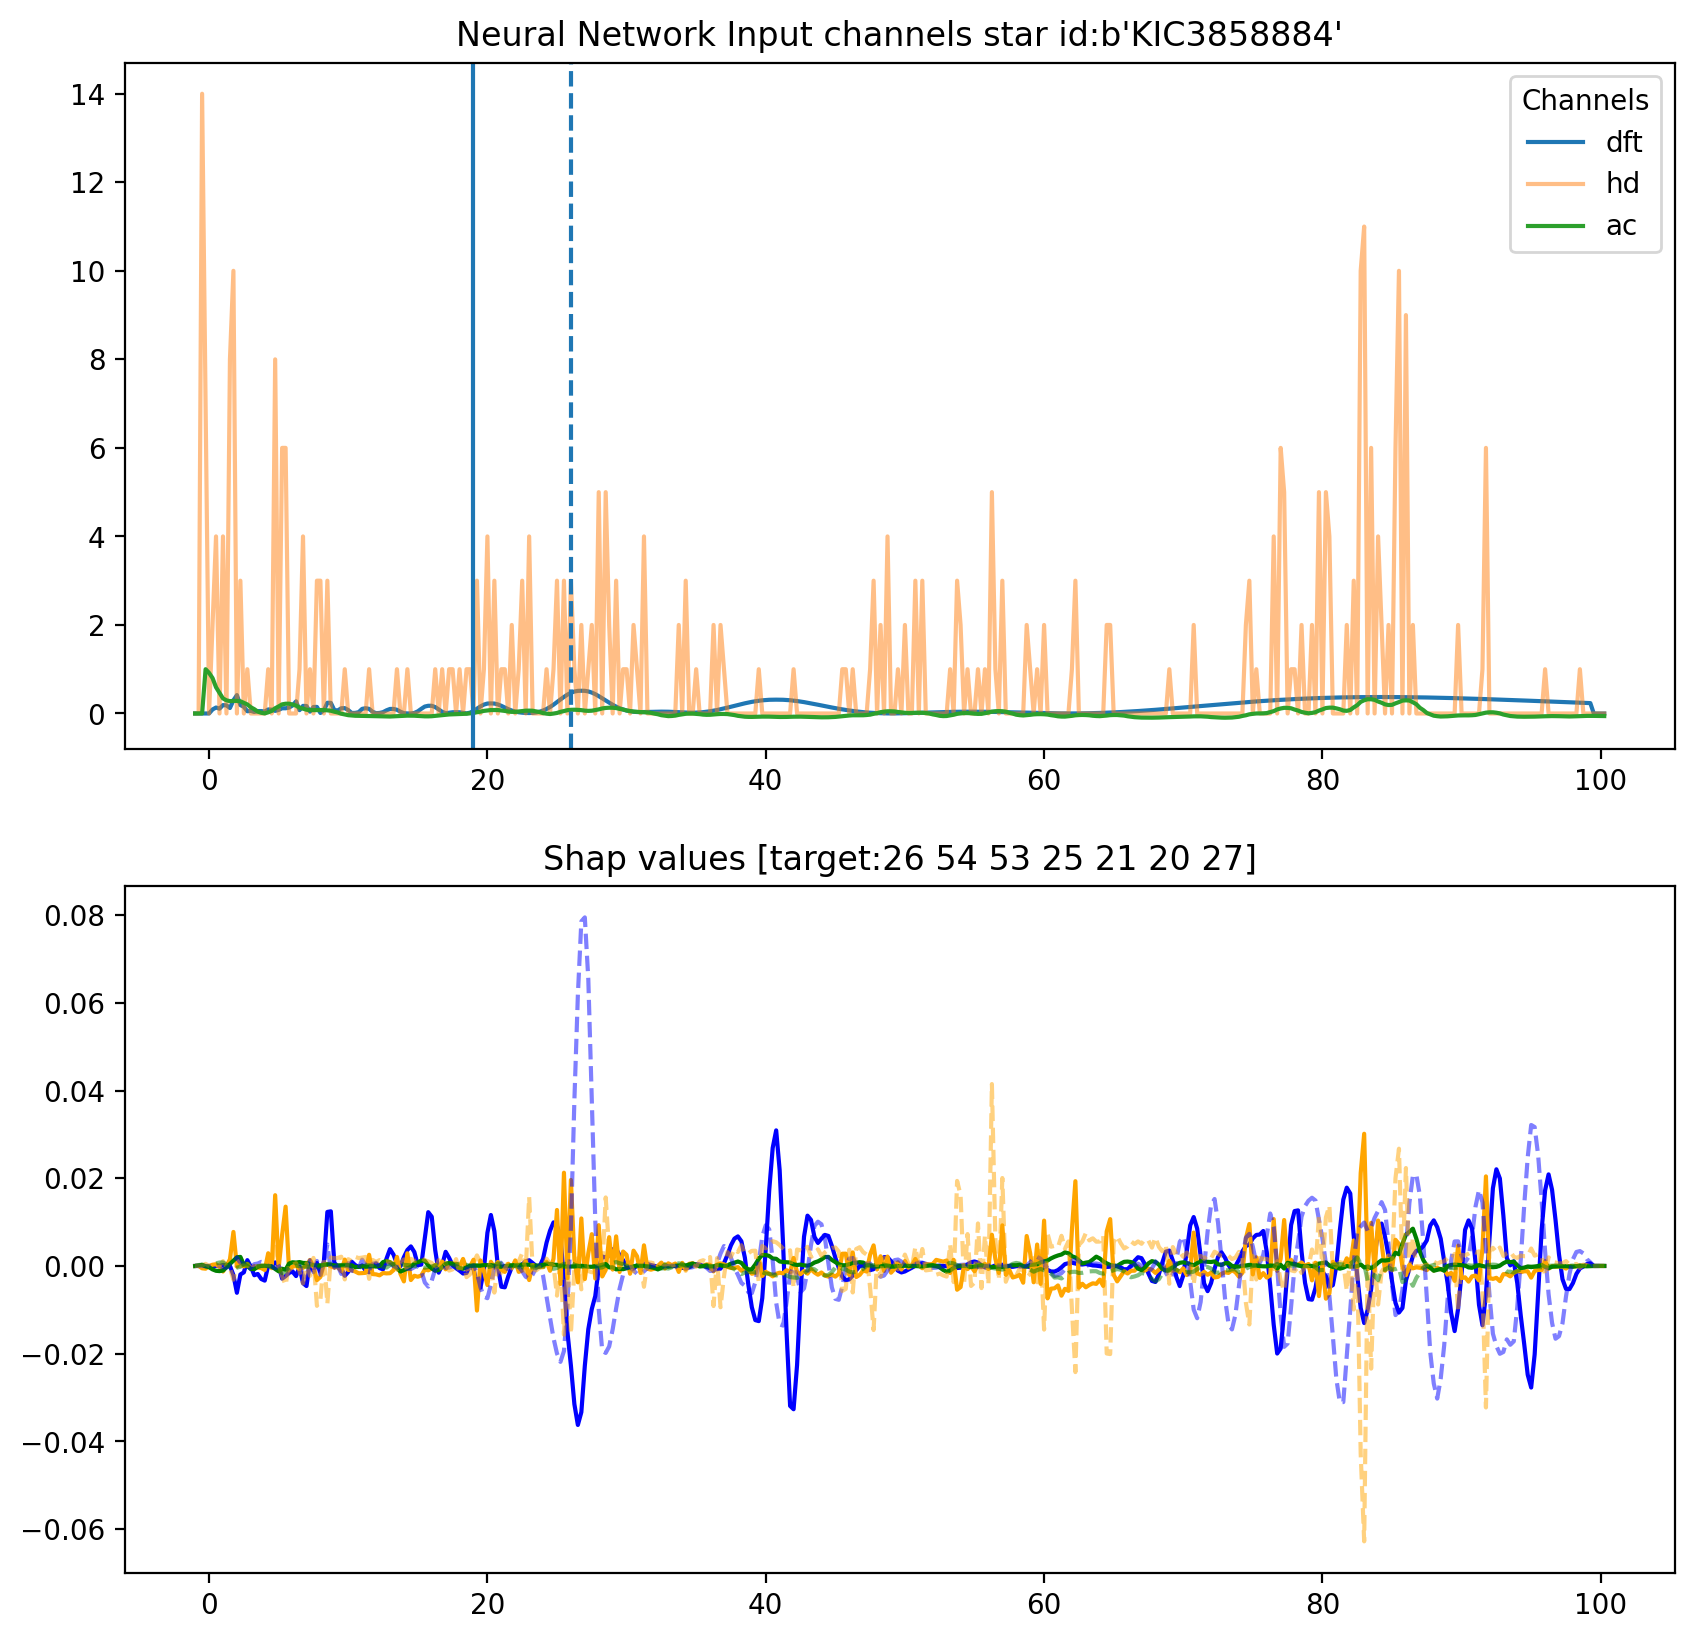

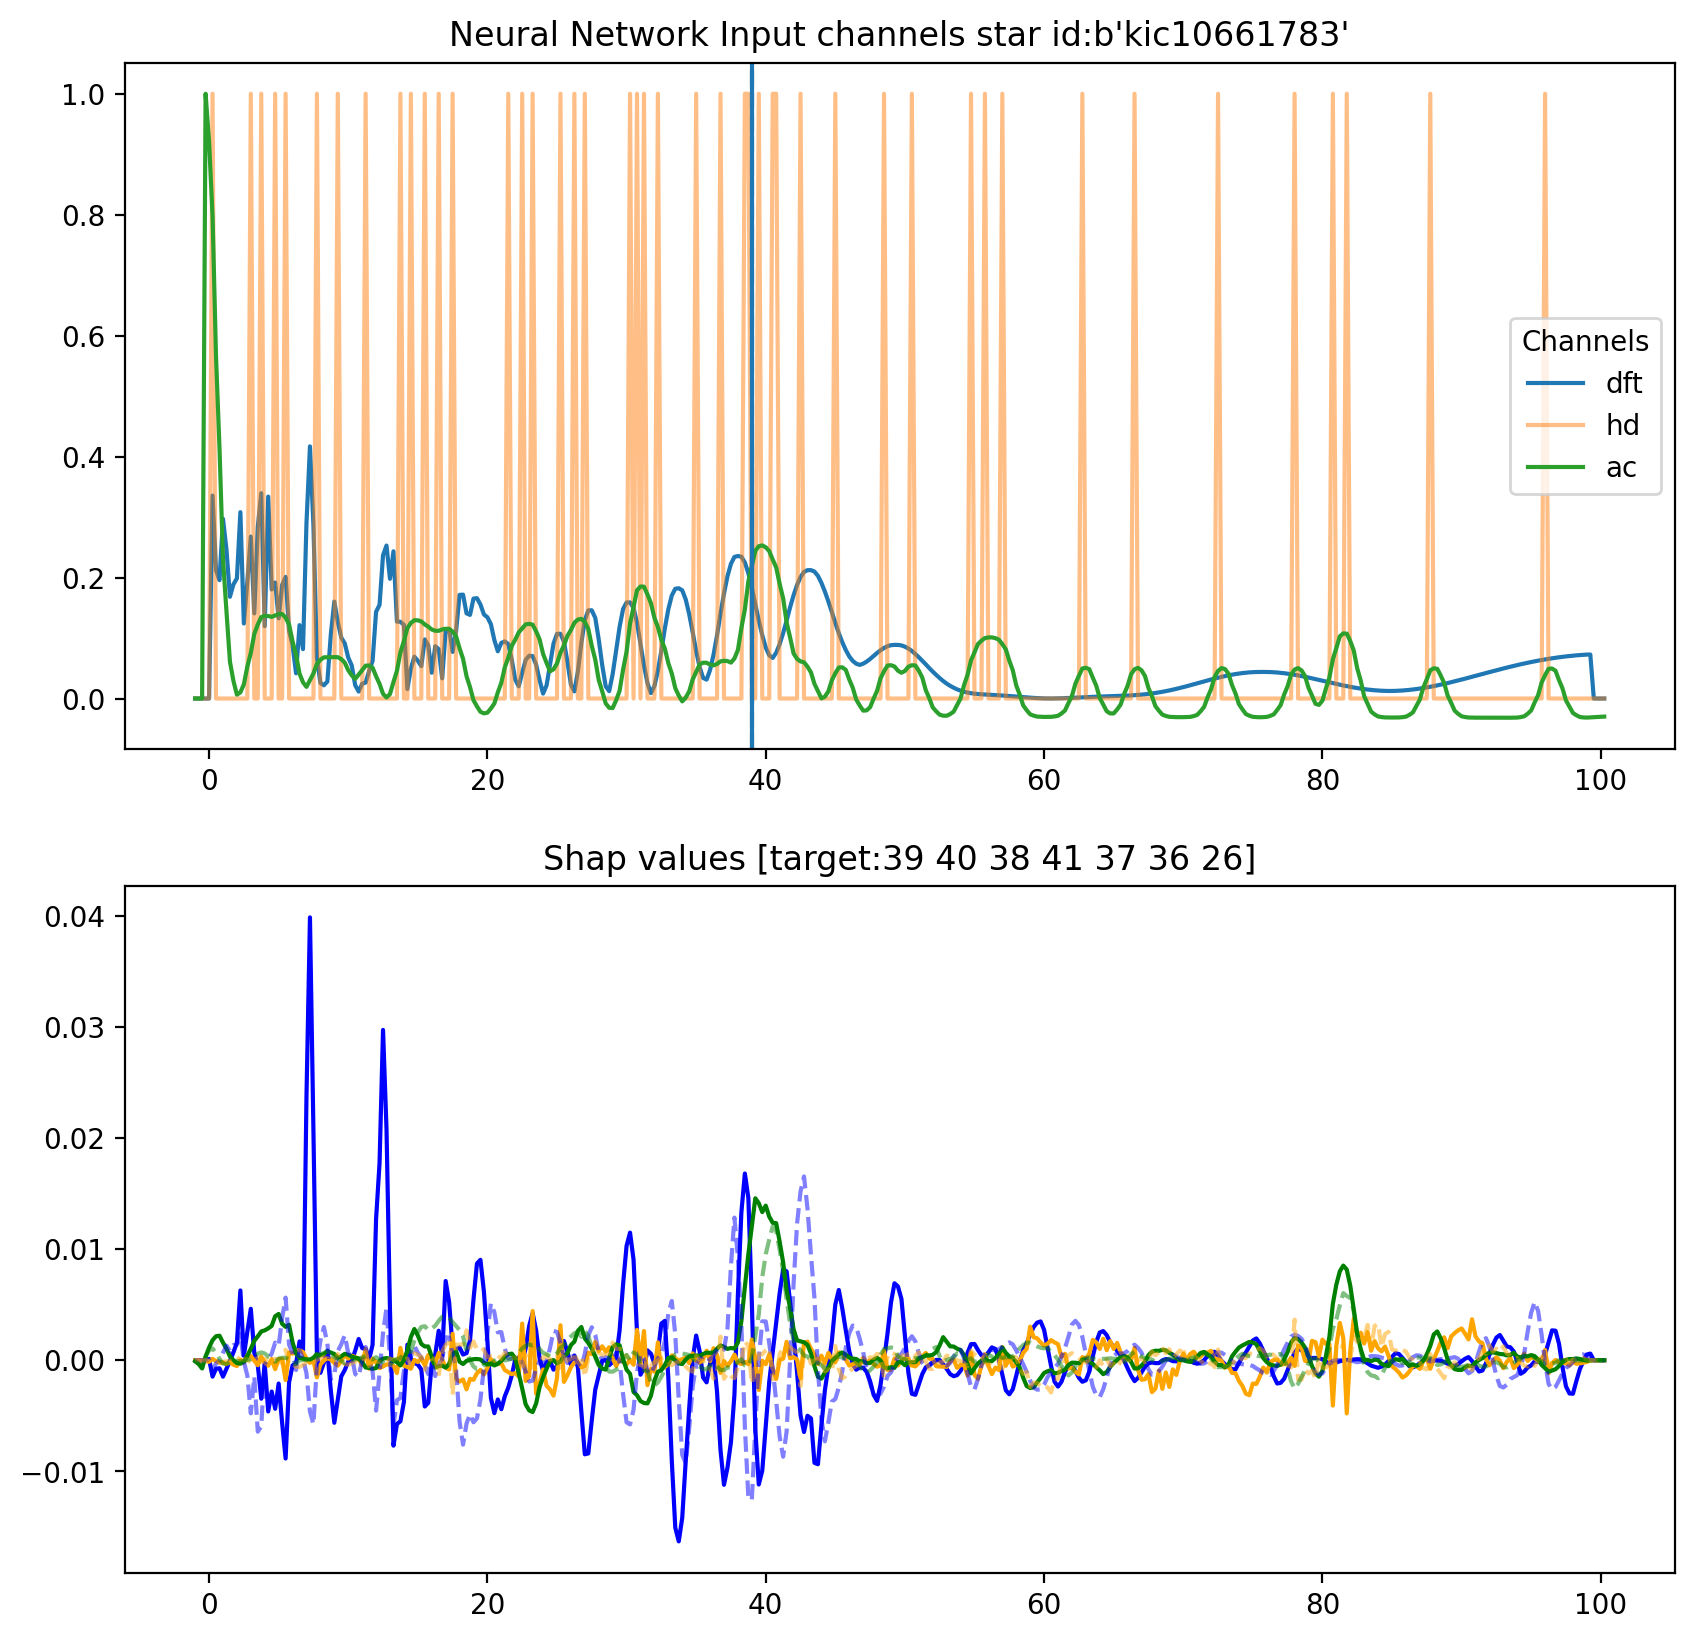

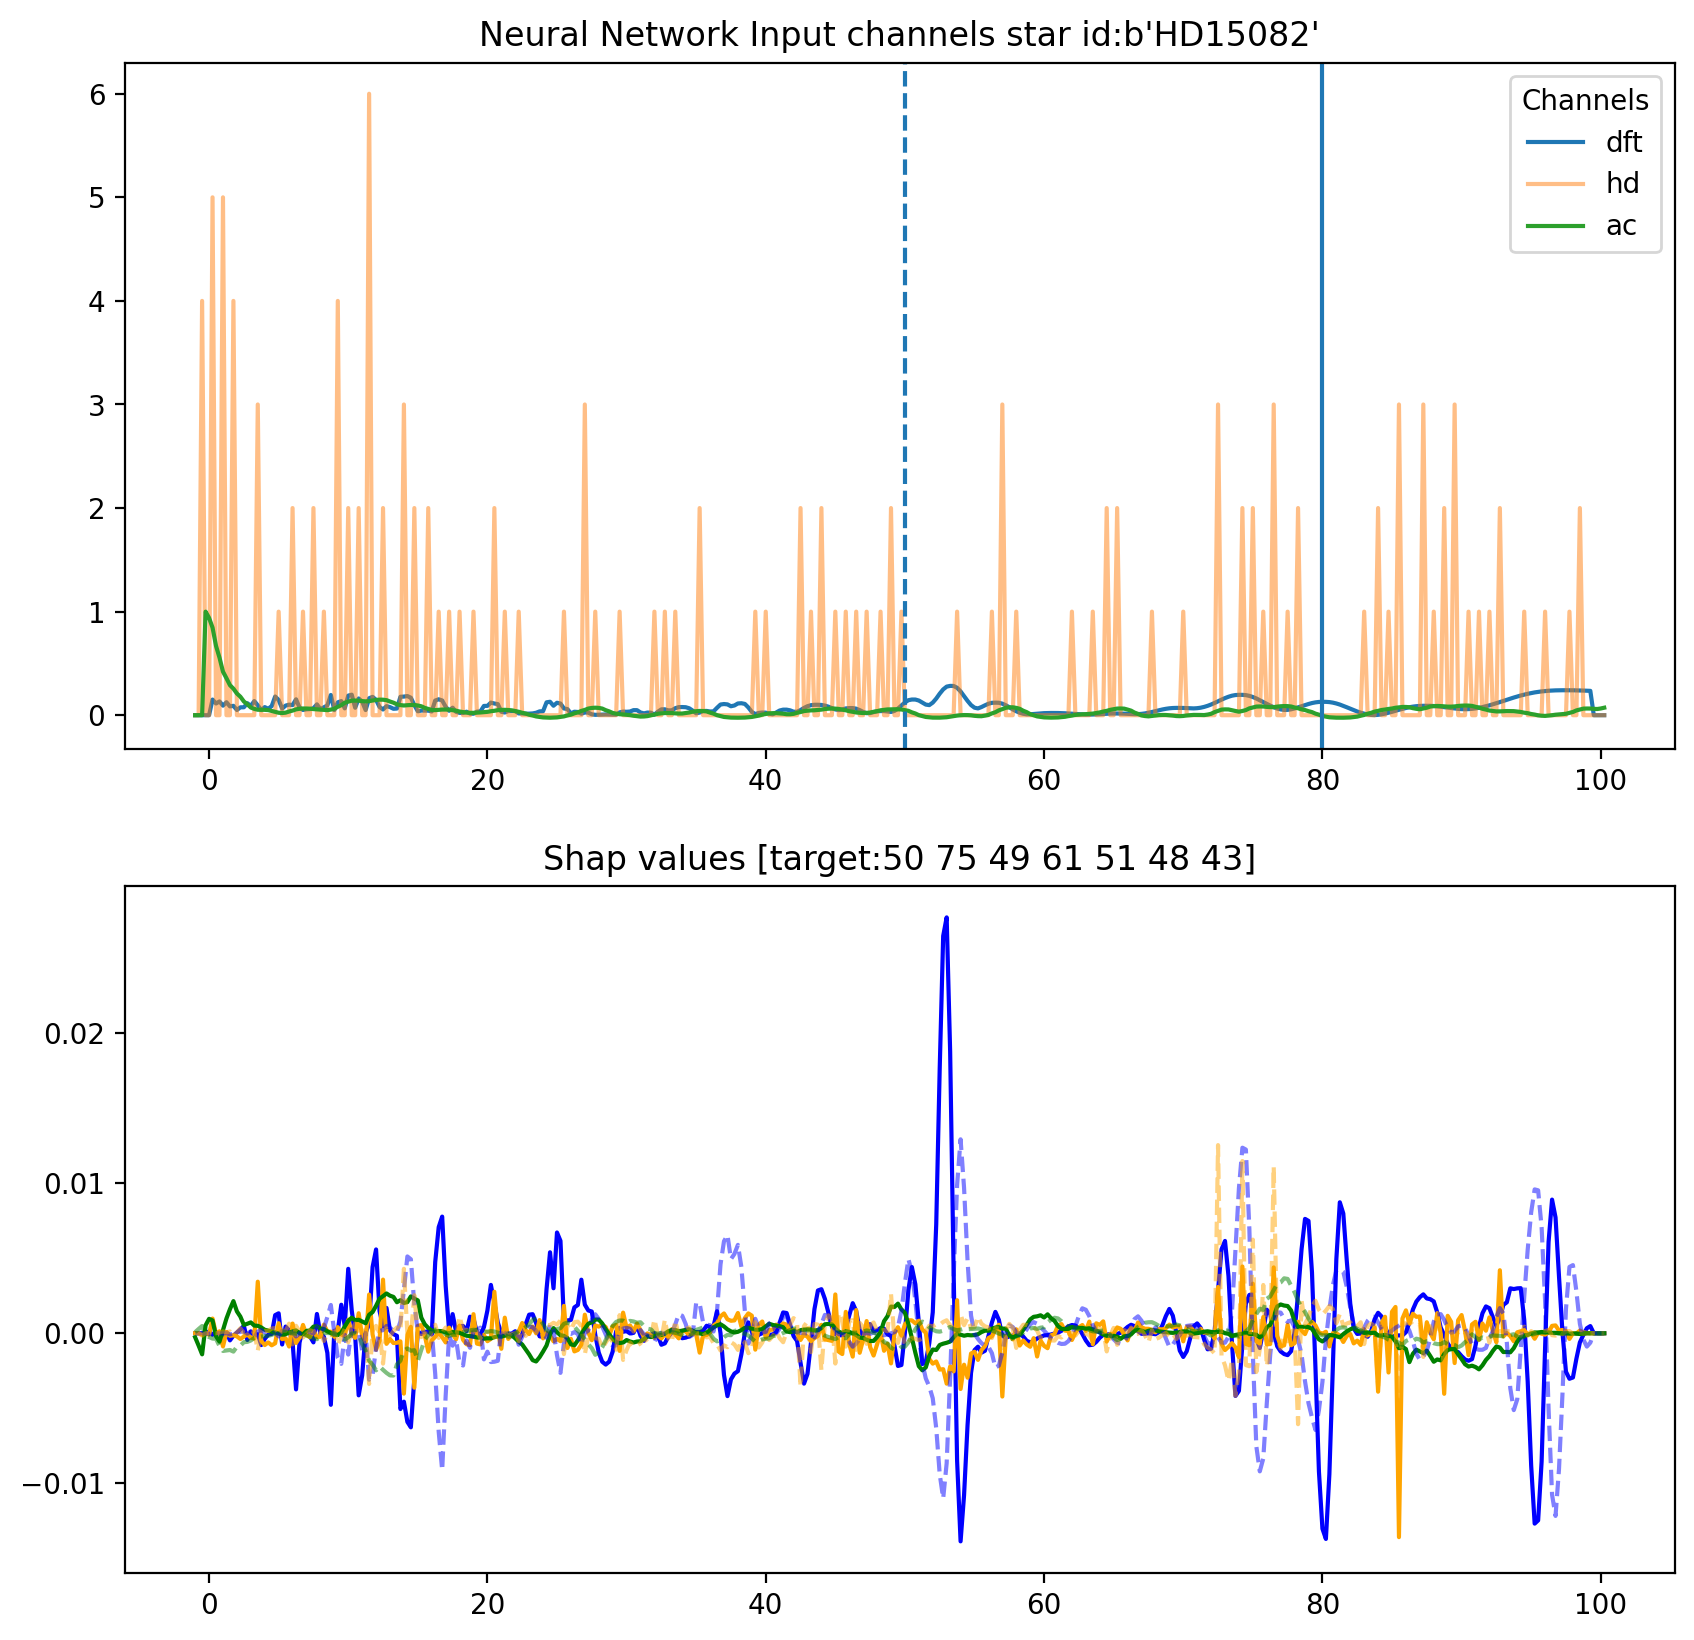

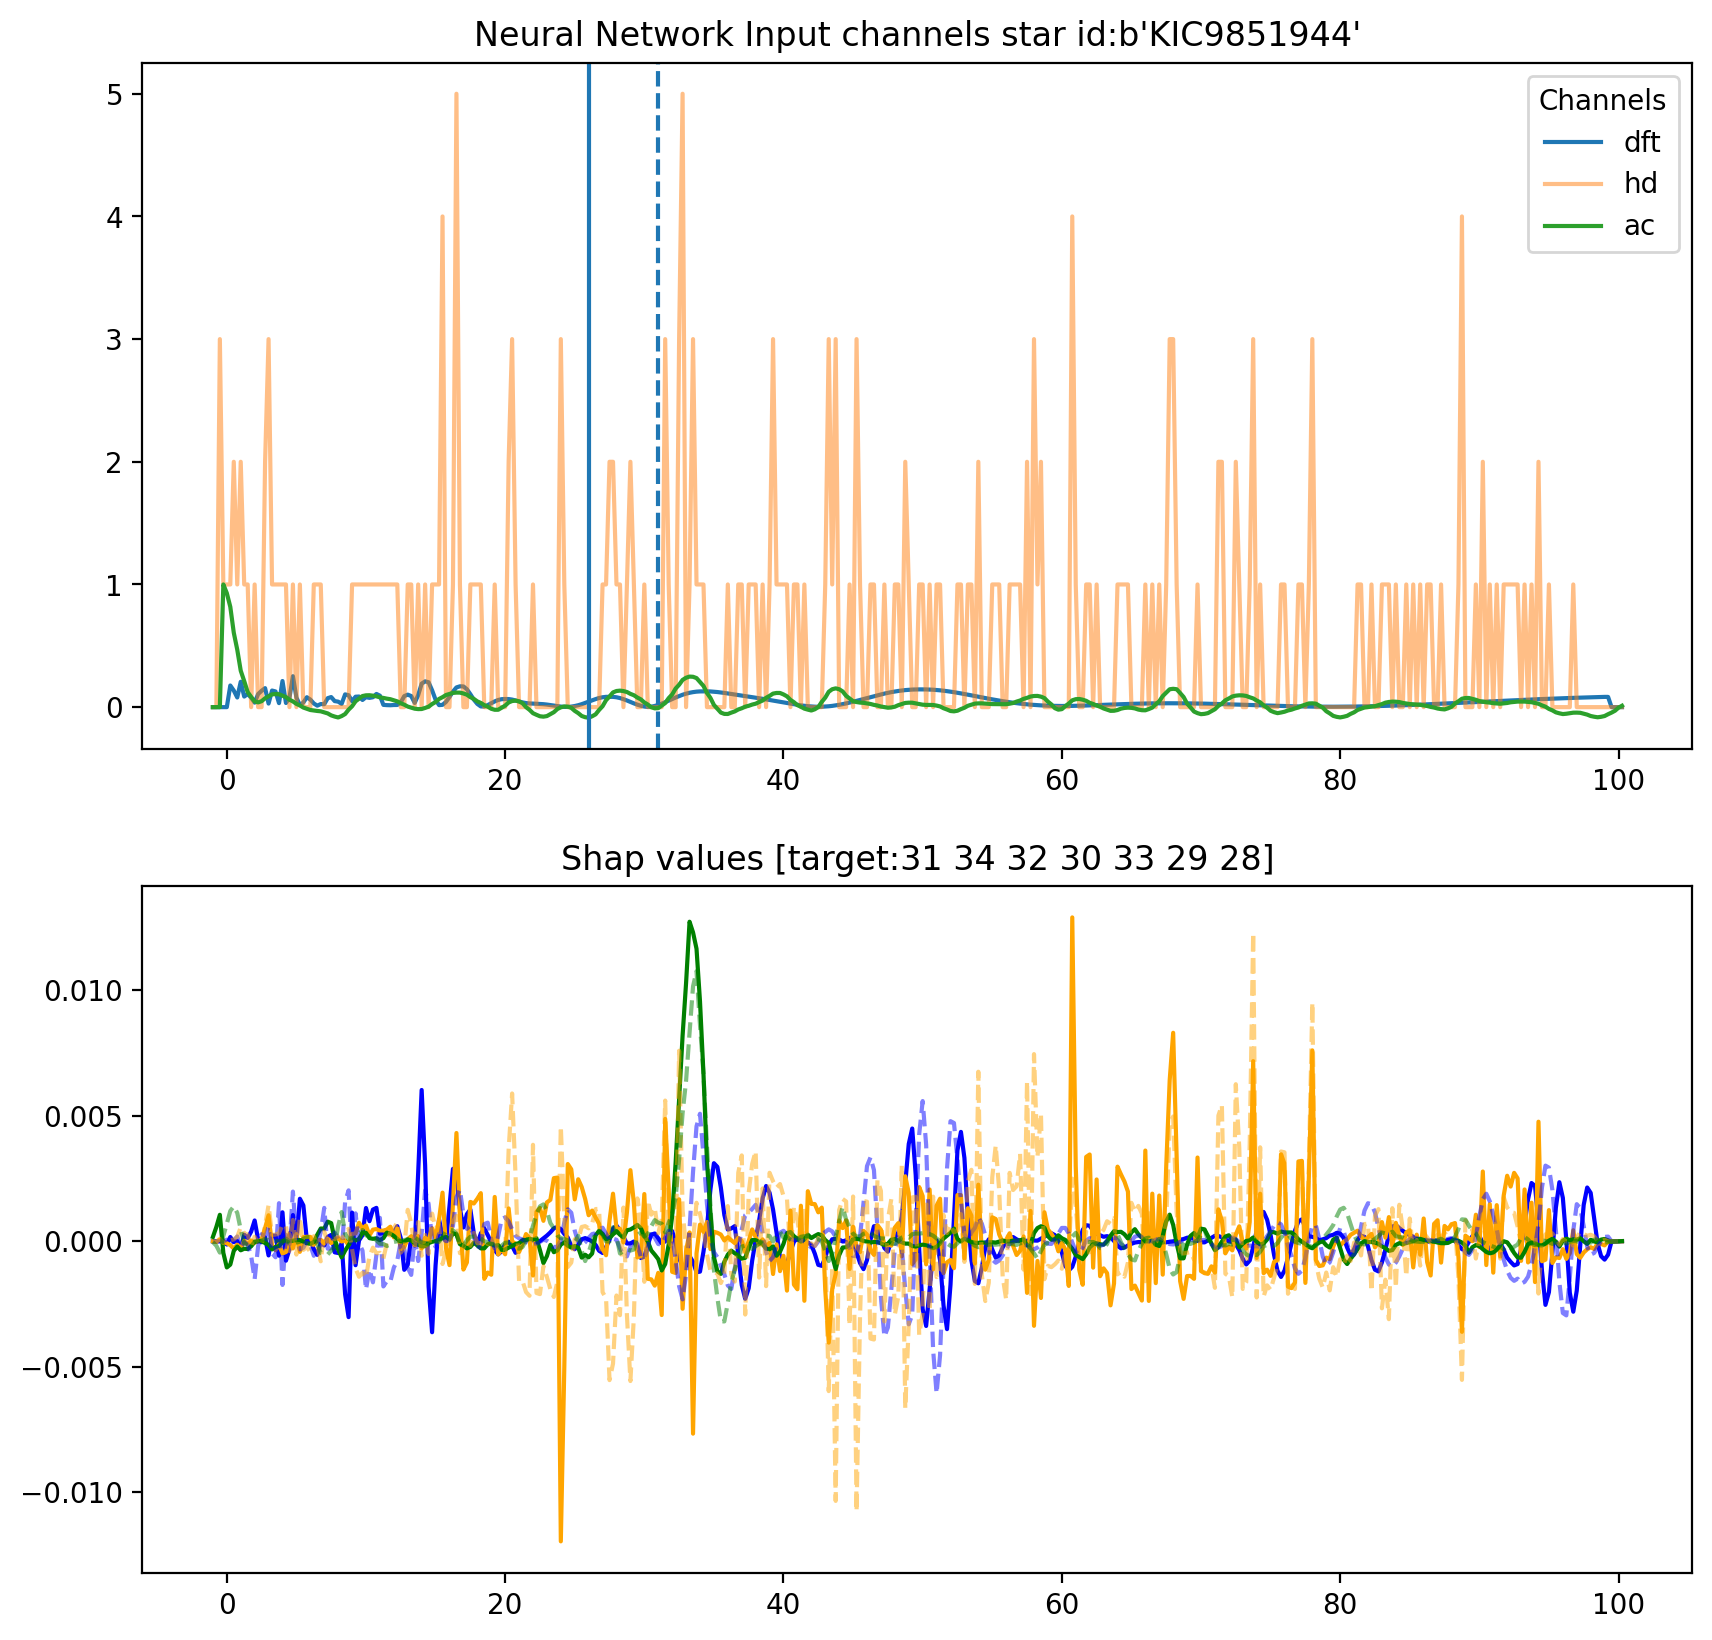

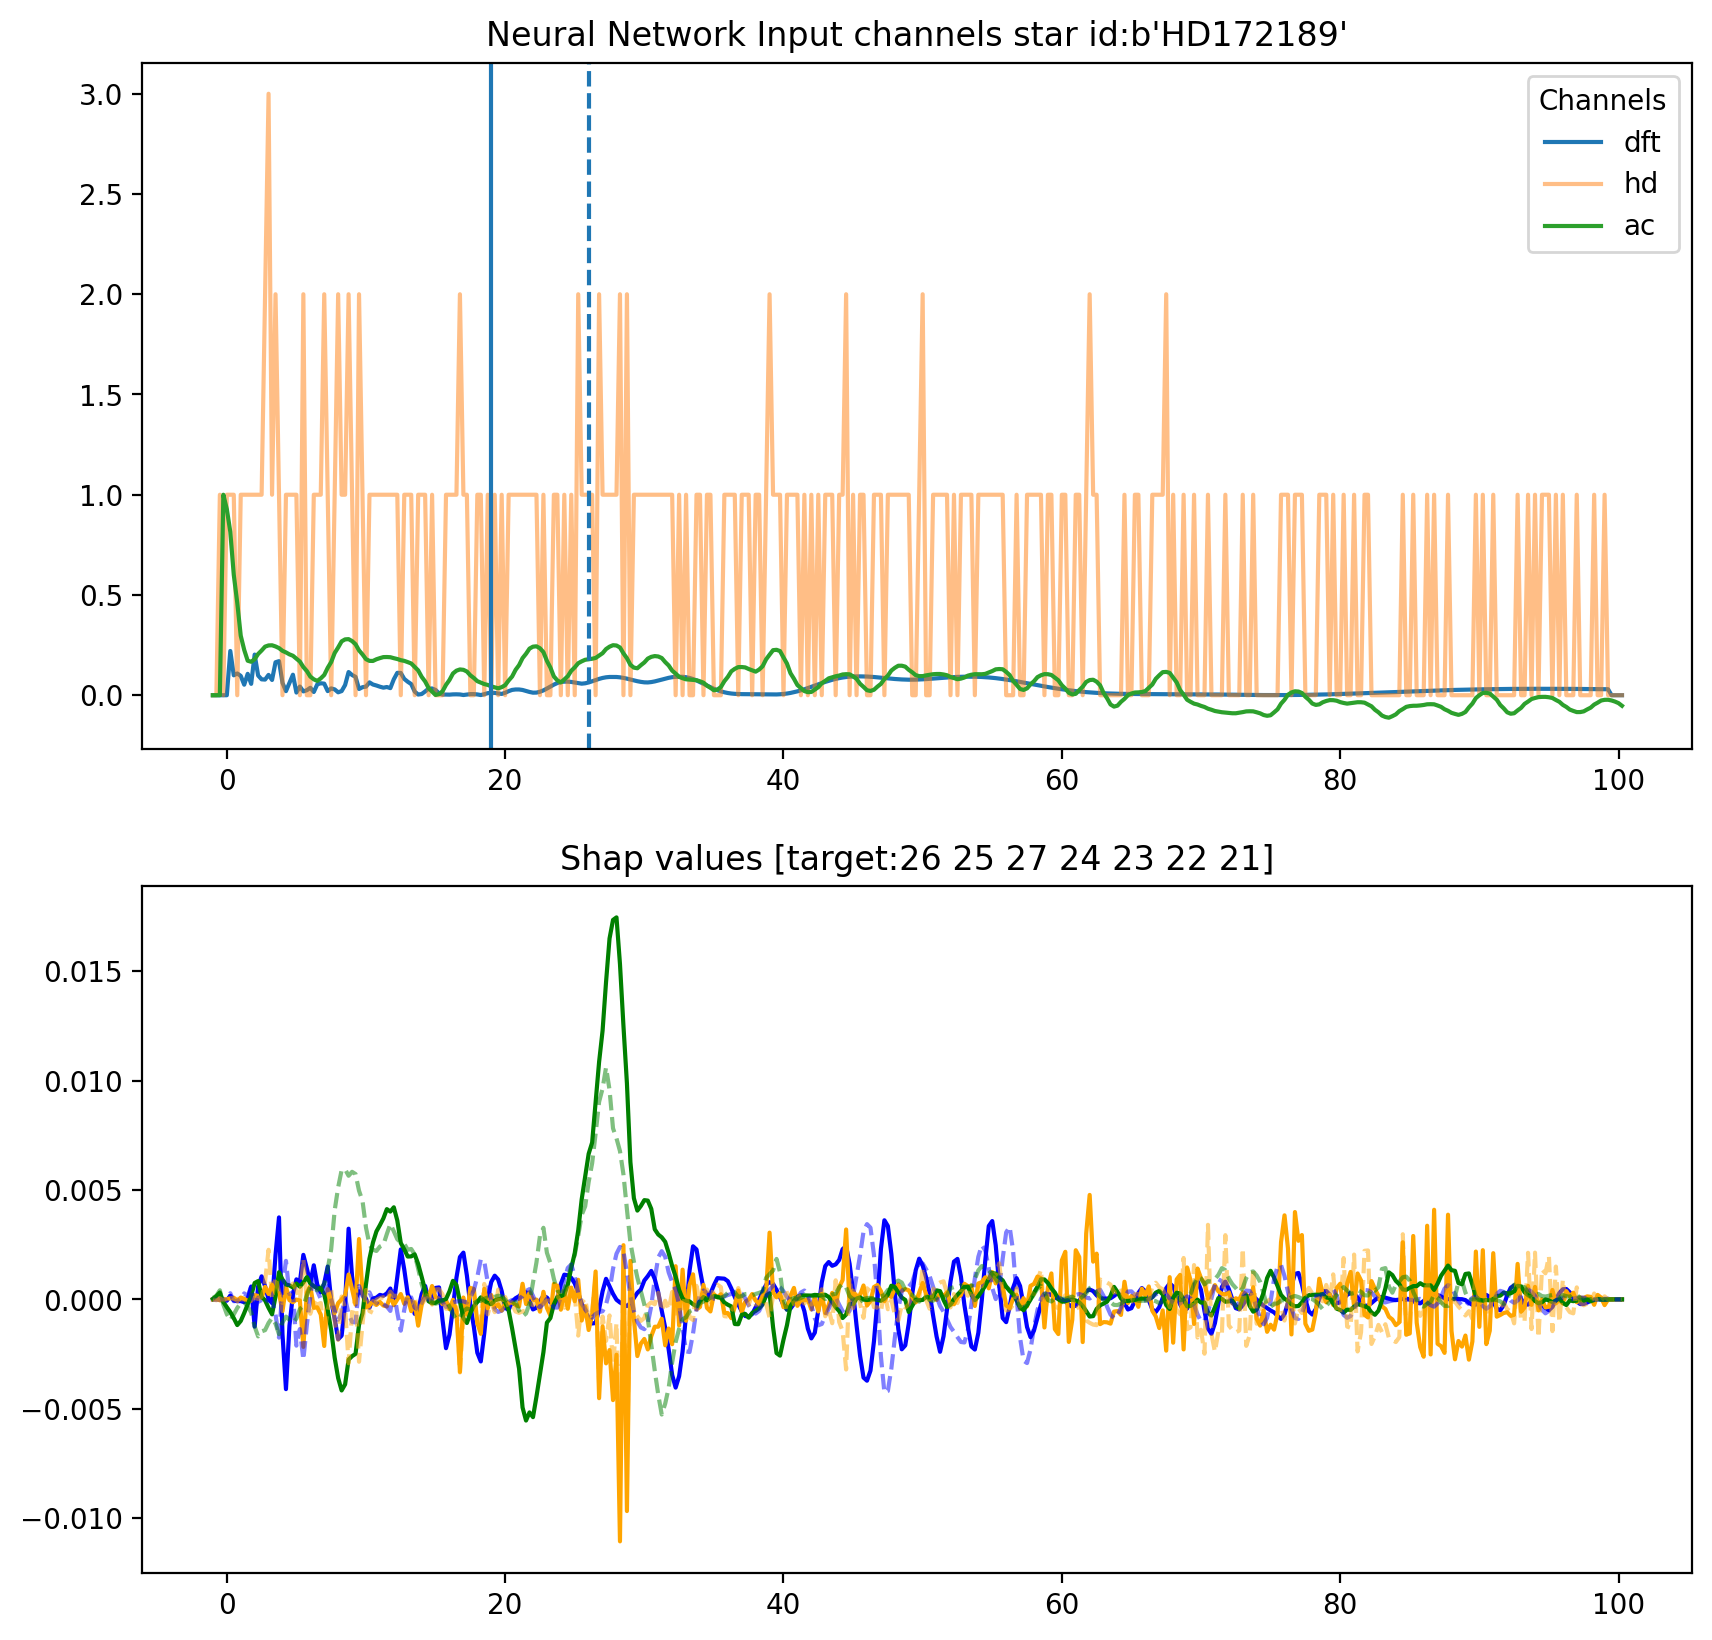

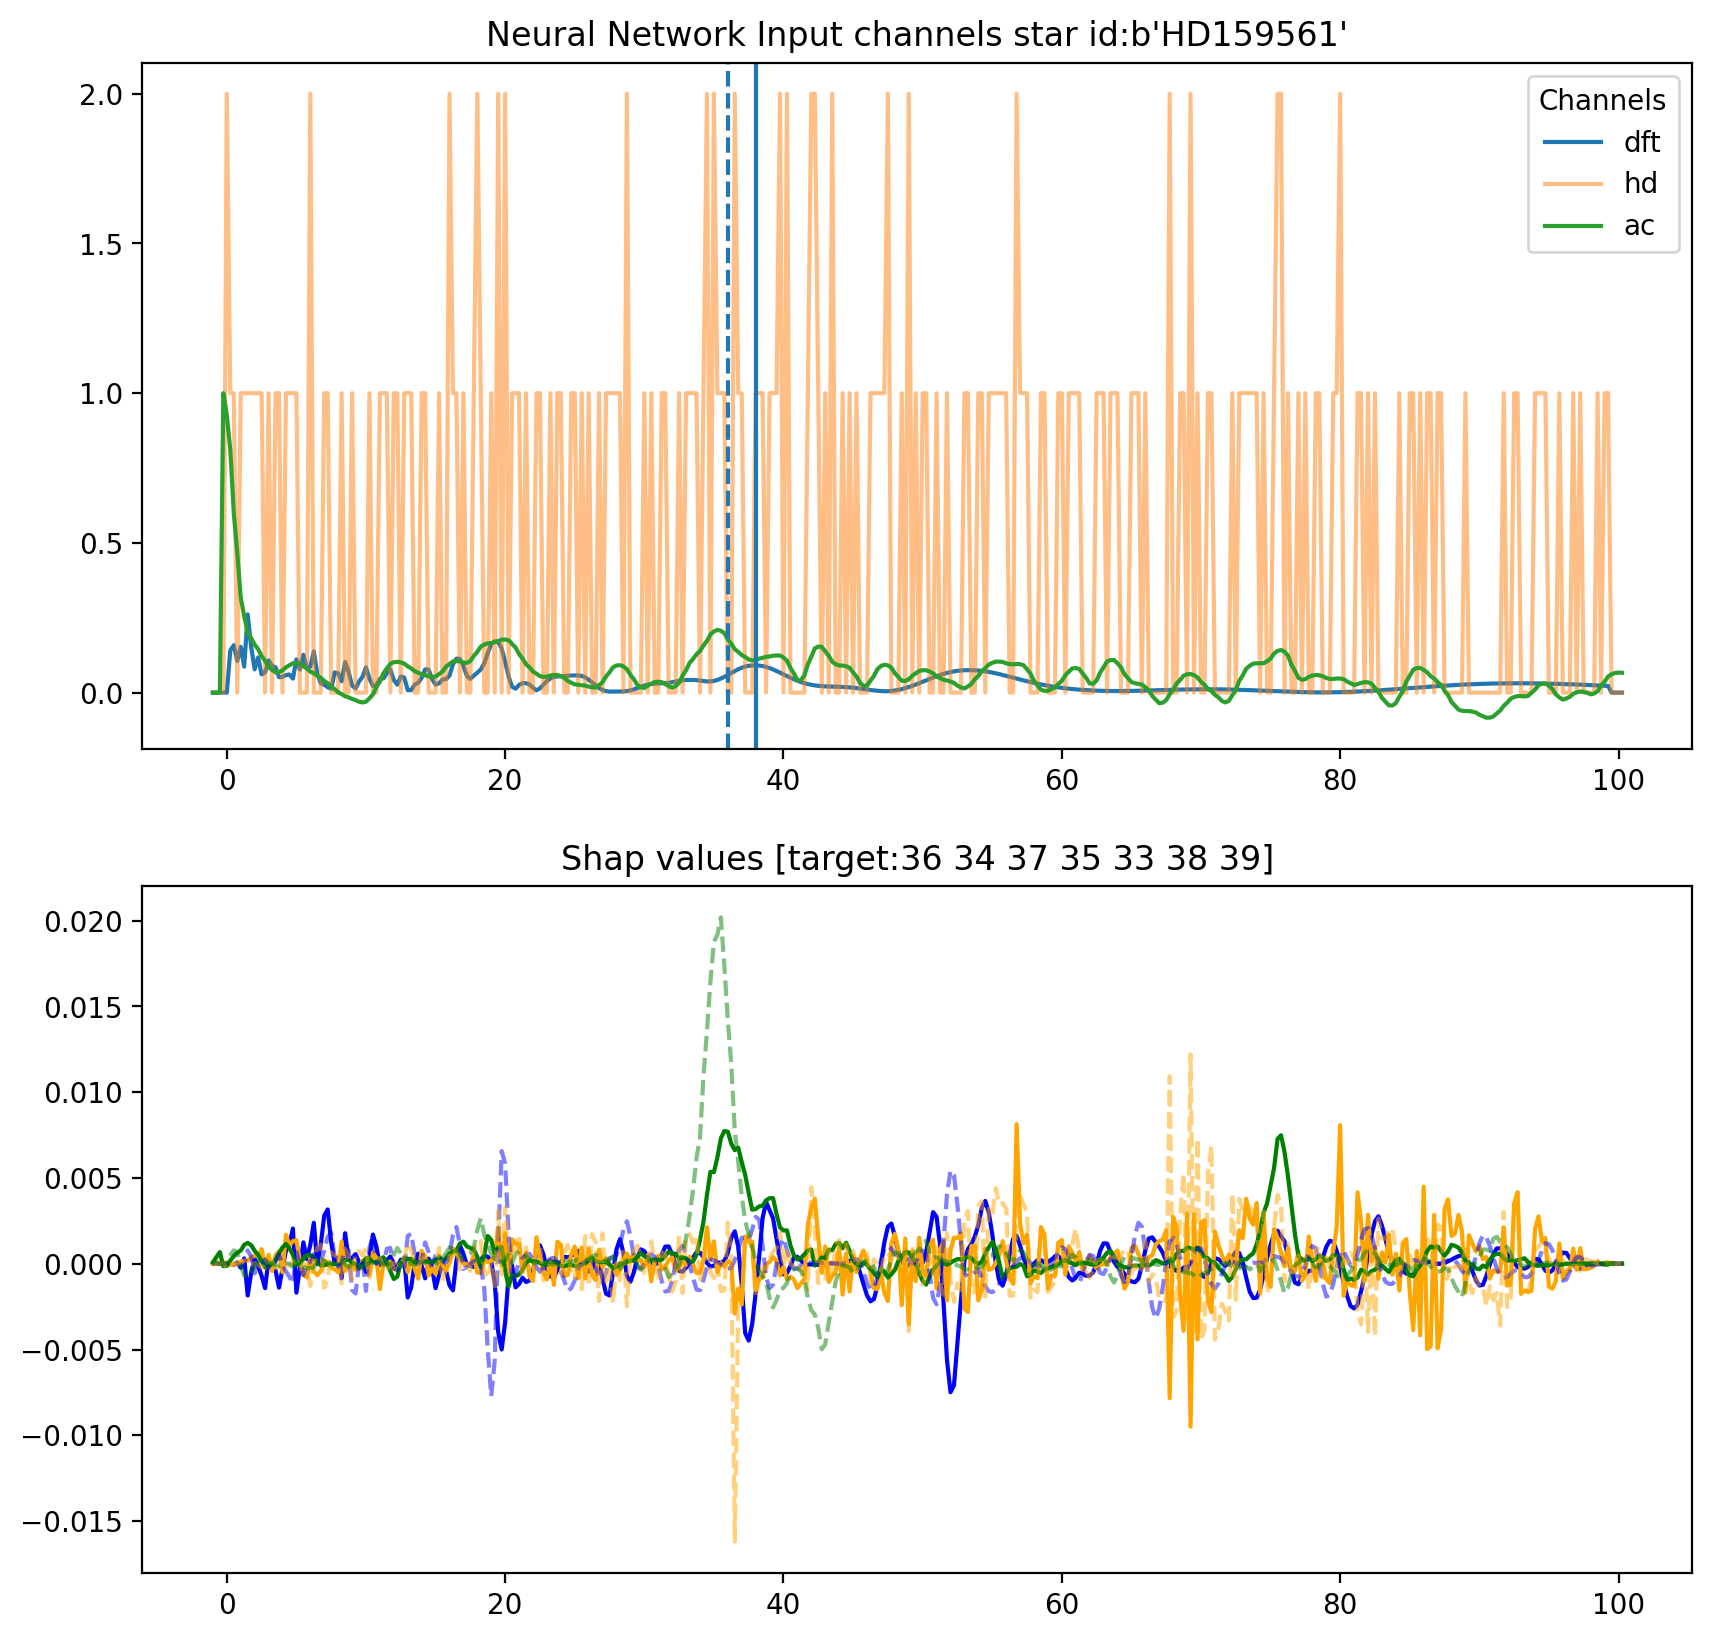

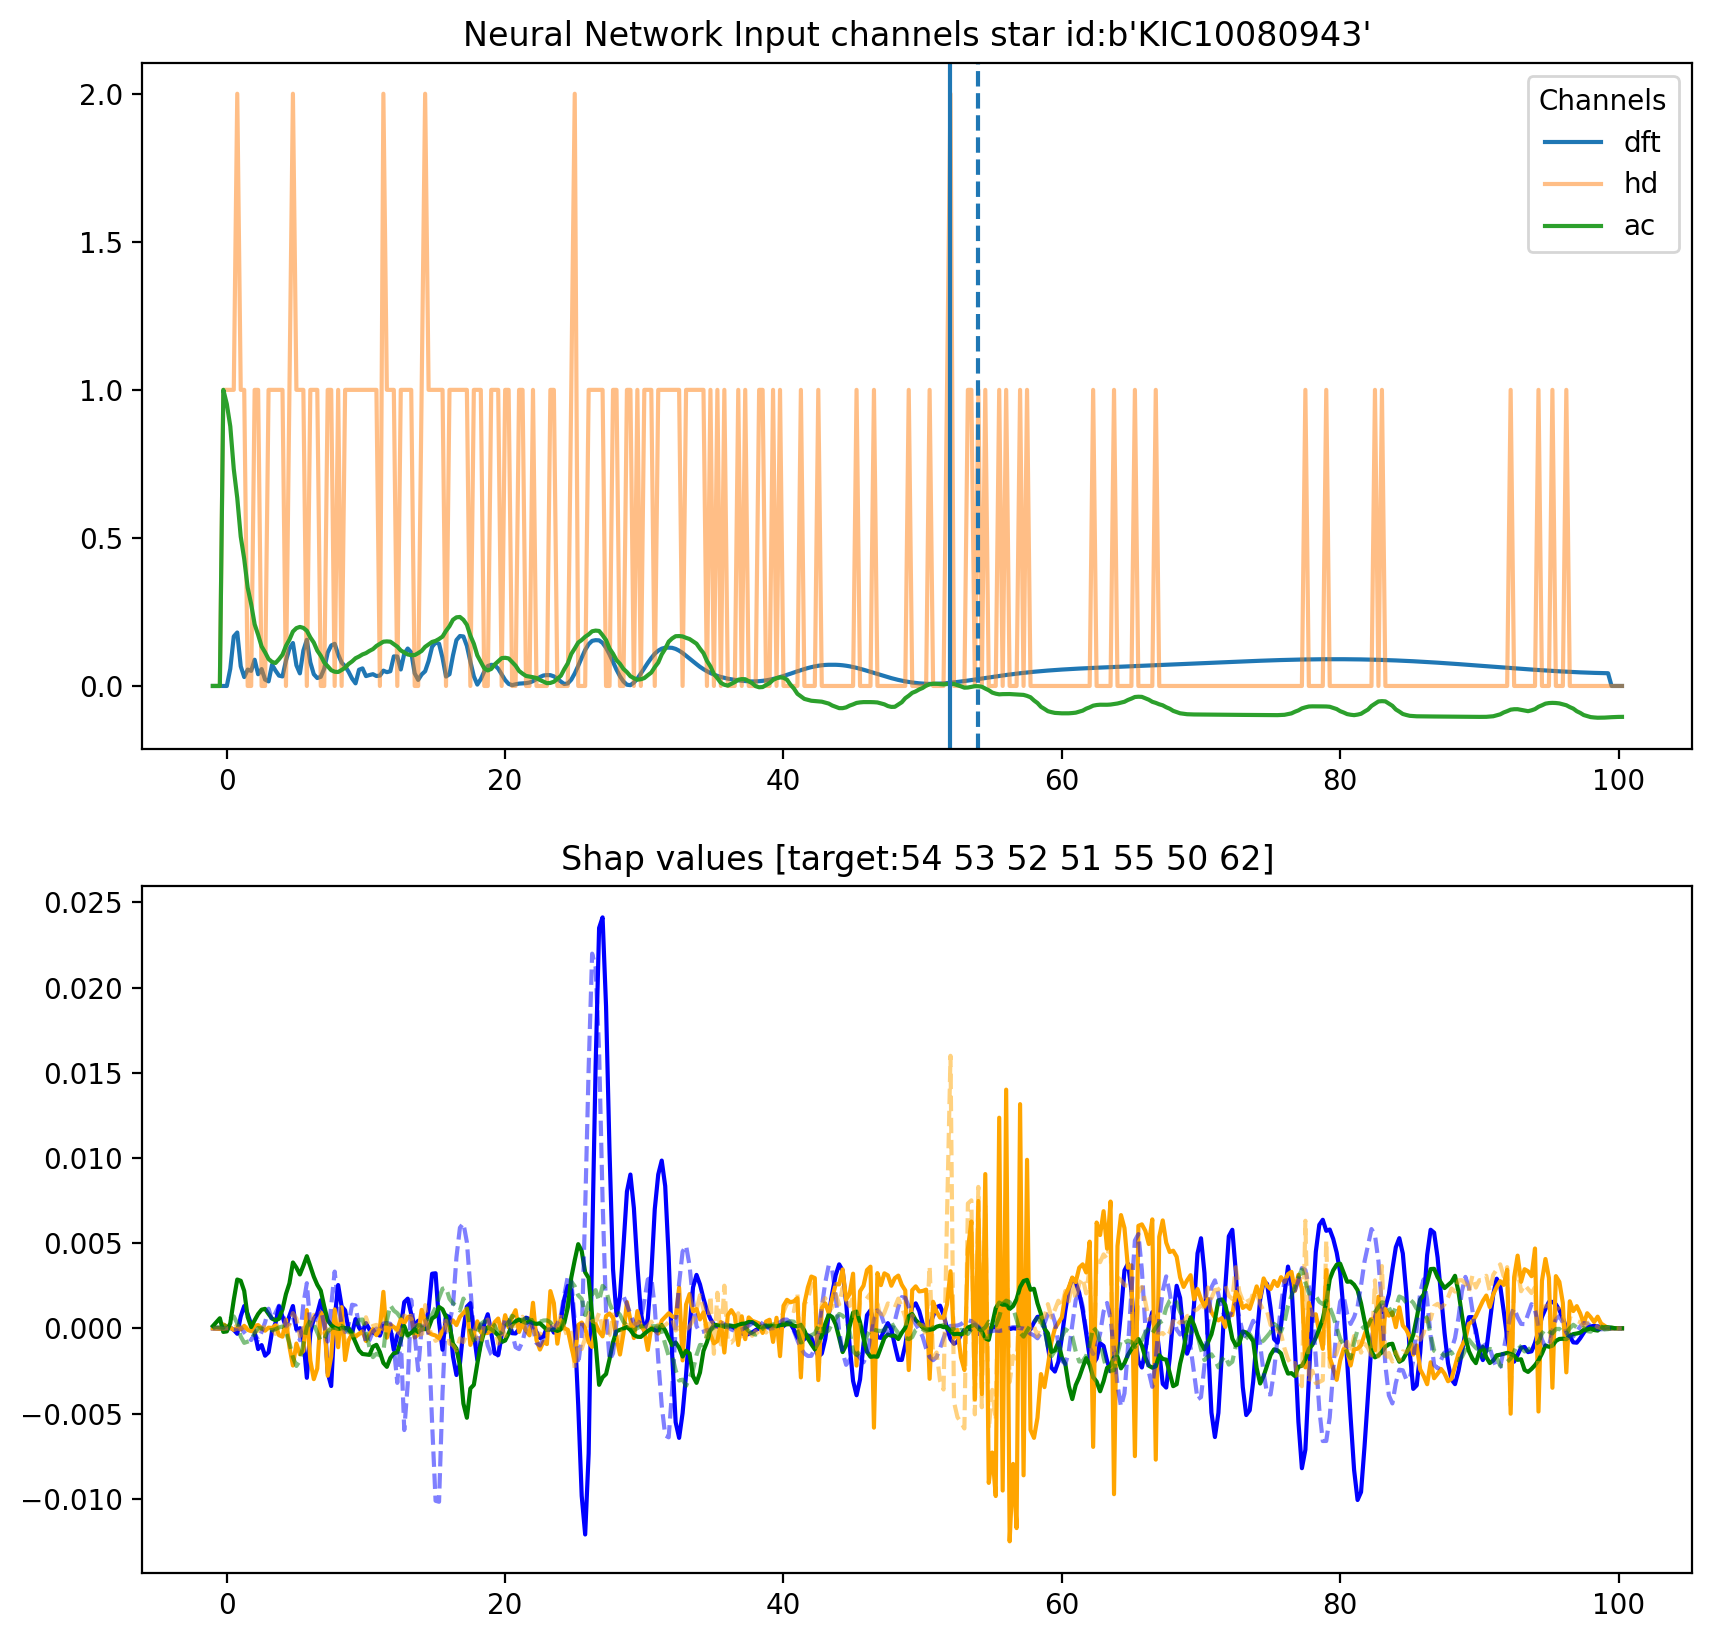

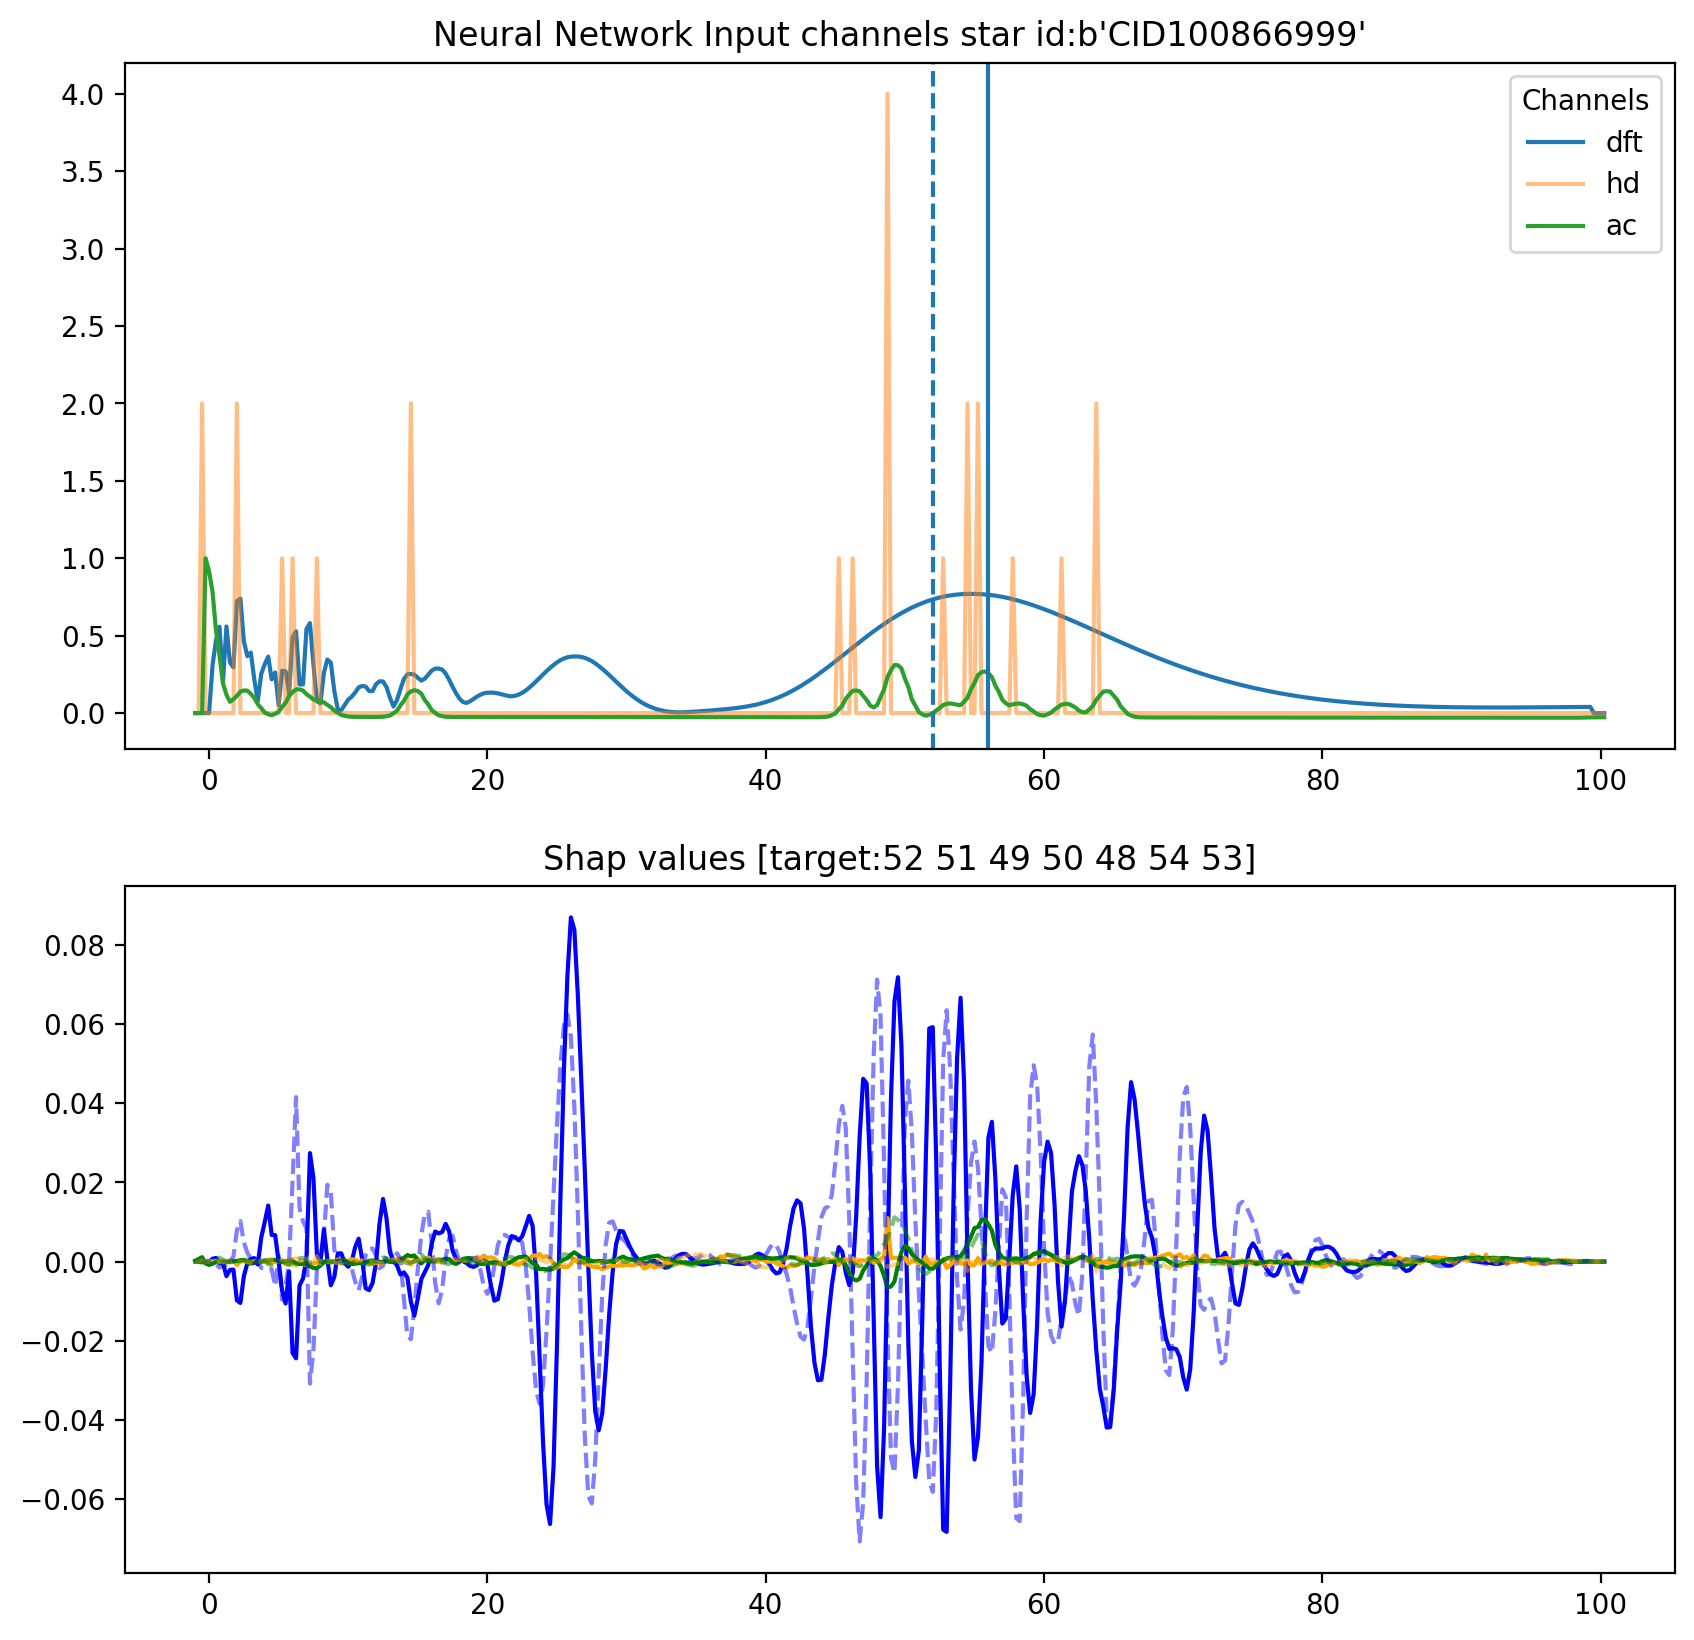

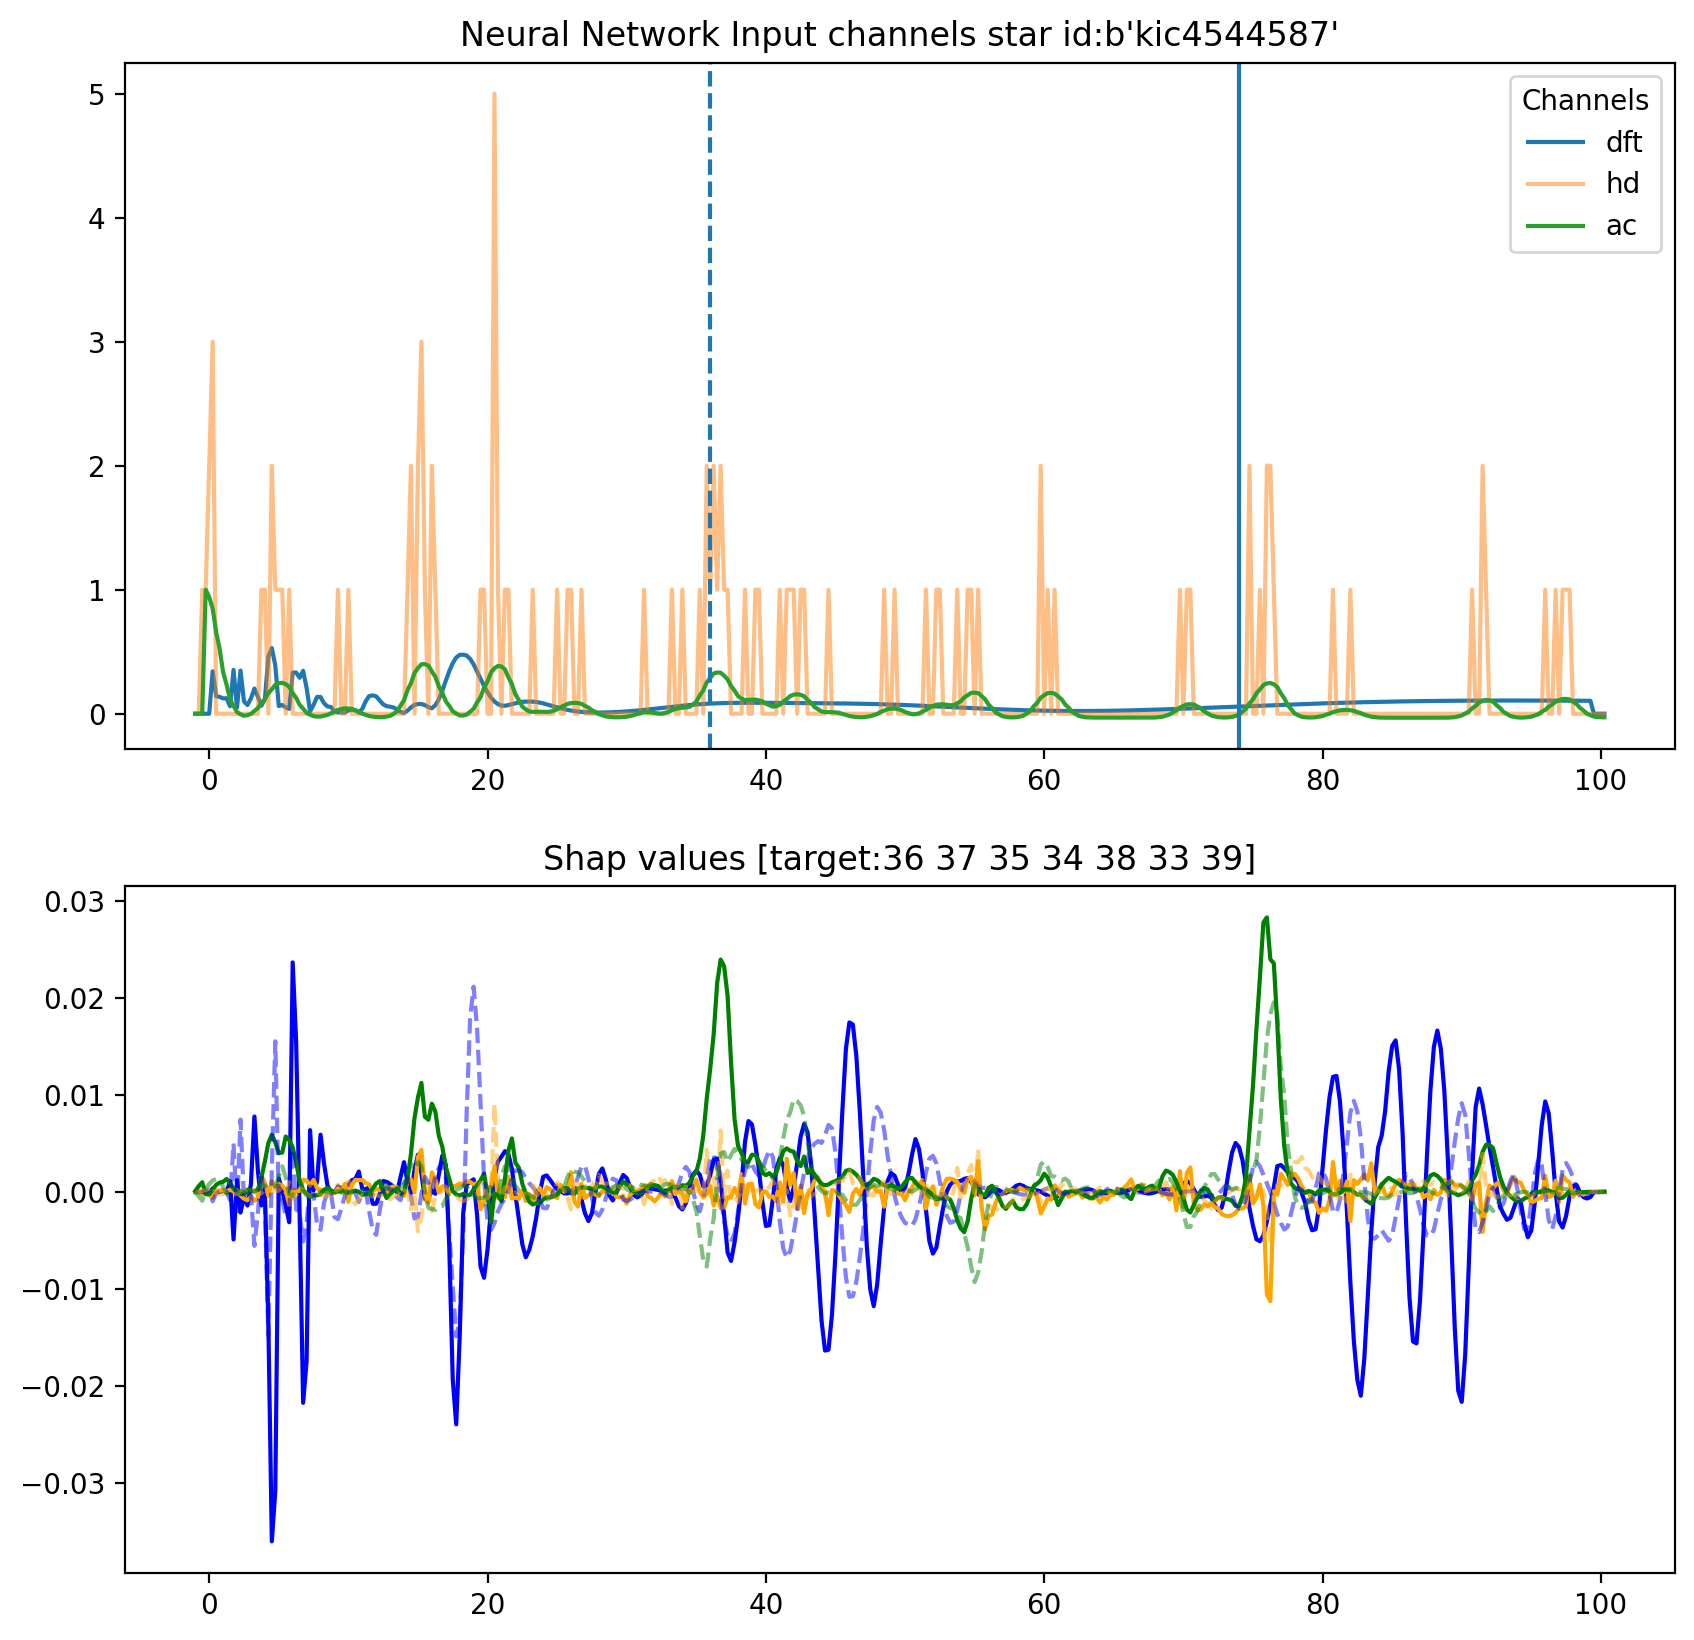

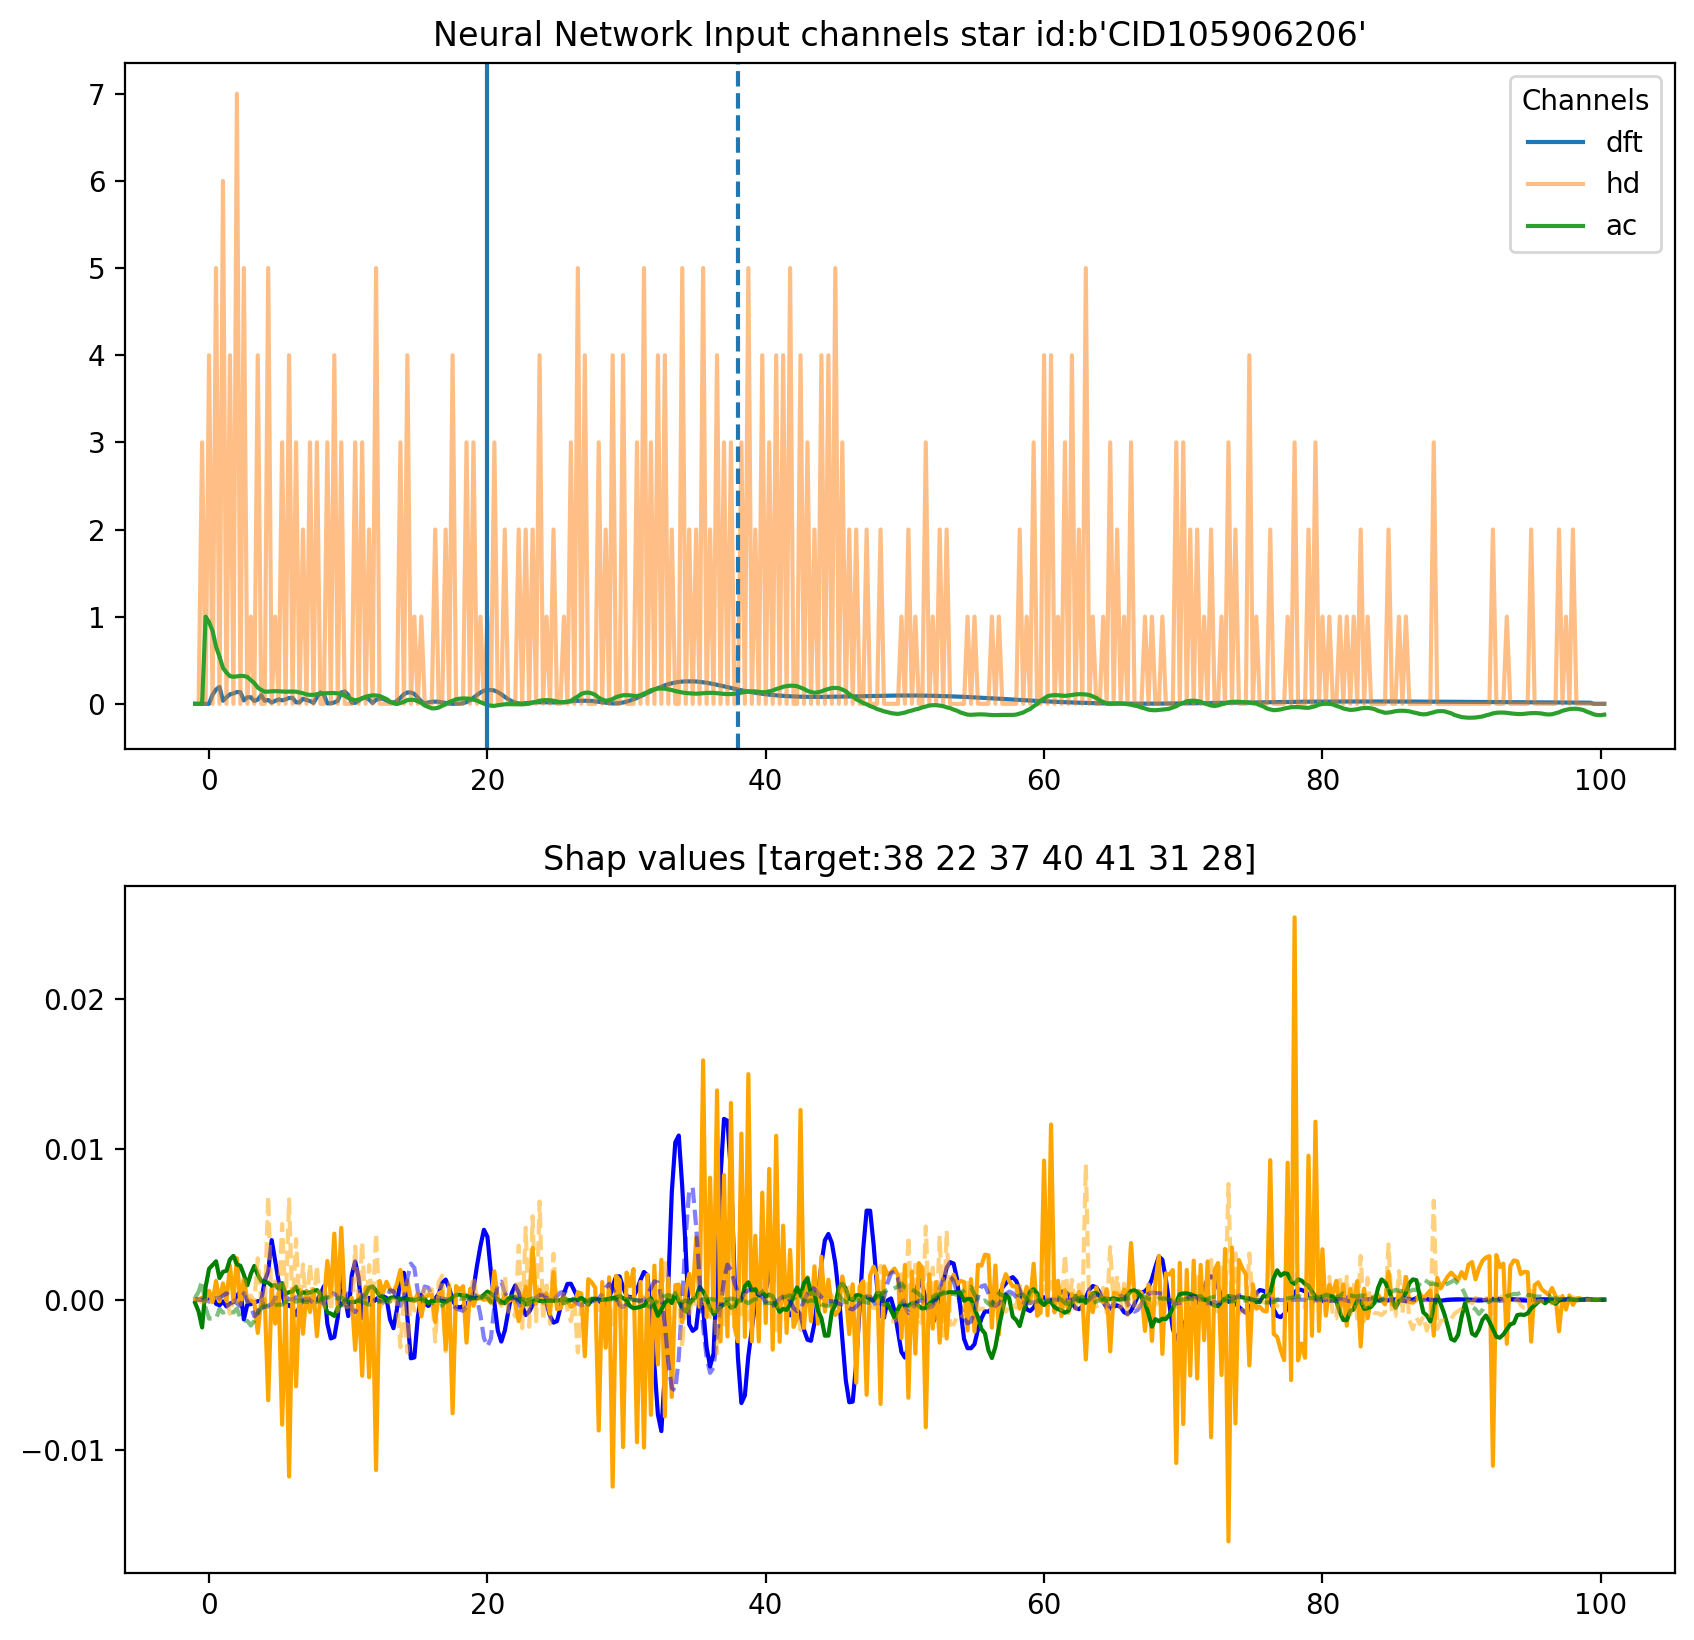

In [5]:
# Read datasets of preprocessed stars
df_ds = deltascuti()
df = df_ds.load("../../astronn/data/deltascuti/preprocessed/*", batch_size=1)
# Read star models (trainning) to calculate shap values
star_models = starmodels()
df_sm = star_models.load("/home/roberto/Downloads/dataall_parts/*", batch_size=150)
_train_shap = np.asarray([line[0].numpy() for line in df_sm.take(10)])
_train_shap = _train_shap.reshape(
    (
        _train_shap.shape[0] * _train_shap.shape[1],
        _train_shap.shape[2],
        _train_shap.shape[3],
    )
)
# Load model
sepconv_mod = tf.keras.models.load_model("/tmp/sepconvnn_tmp_99")

x = np.arange(-1, 100.5, 0.25)  # x axis from 0 to 100

for star in df.take(11):  # take the 11 ds stars
    target = np.where(star[2].numpy().flat == 1)[0].flat[0]
    # Plot information about ds star
    fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10), dpi=200)
    ax1.plot(x, star[1][0, :, 0].numpy(), label="dft")
    ax1.plot(x, star[1][0, :, 1].numpy(), alpha=0.5, label="hd")
    ax1.plot(x, star[1][0, :, 2].numpy(), label="ac")
    target = np.where(star[2].numpy().flat == 1)[0].flat[0]
    ax1.axvline(x=target)
    ax1.axvline(x=sepconv_mod.predict_classes(star[1]), linestyle="--")
    # Calculate gradient explainers and shap values
    e = shap.GradientExplainer(
        sepconv_mod, _train_shap, batch_size=10, local_smoothing=0
    )
    shap_values, indexes = e.shap_values(
        star[1].numpy(), nsamples=100, ranked_outputs=10
    )
    print(indexes)
    # Plot shap
    ax2.plot(x, shap_values[0][0][:, [0]], label="dft", linestyle="solid", color="blue")
    ax2.plot(
        x, shap_values[0][0][:, [1]], label="hd", linestyle="solid", color="orange"
    )
    ax2.plot(x, shap_values[0][0][:, [2]], label="ac", linestyle="solid", color="green")
    ax2.plot(
        x,
        shap_values[1][0][:, [0]],
        label="dft",
        linestyle="--",
        color="blue",
        alpha=0.5,
    )
    ax2.plot(
        x,
        shap_values[1][0][:, [1]],
        label="hd",
        linestyle="--",
        color="orange",
        alpha=0.5,
    )
    ax2.plot(
        x,
        shap_values[1][0][:, [2]],
        label="ac",
        linestyle="--",
        color="green",
        alpha=0.5,
    )

    ax1.legend(title="Channels")
    ax1.title.set_text("Neural Network Input channels" + " star id:" + str(star[0].numpy()[0]))
    ax2.title.set_text(
        "Shap values"
        + " [target:"
        + str(indexes[0][0])
        + " "
        + str(indexes[0][1])
        + " "
        + str(indexes[0][2])
        + " "
        + str(indexes[0][3])
        + " "
        + str(indexes[0][4])
        + " "
        + str(indexes[0][5])
        + " "
        + str(indexes[0][6])
        + "]"
    )
    fig.show()

In [6]:
cid = None
for star in df.take(11):  # take the 11 ds stars
    print(str(star[0].numpy()[0]))
    if star[0].numpy()[0].decode("utf-8") == 'CID100866999':
        cid = star

b'KIC3858884'
b'HD15082'
b'KIC9851944'
b'kic4544587'
b'HD159561'
b'CID100866999'
b'KIC8262223'
b'kic10661783'
b'HD172189'
b'KIC10080943'
b'CID105906206'


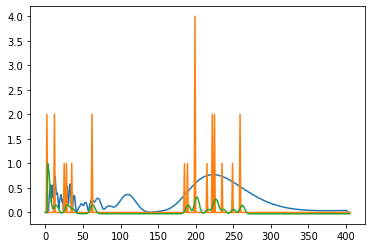

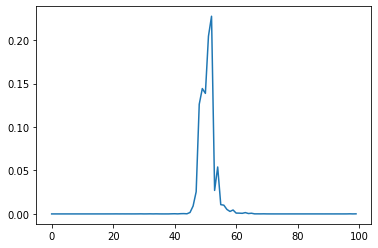

In [7]:
x = cid[1].numpy()

#x[0, 0:400, 0] = 0.5

plt.plot(x[0, :, 0])
plt.plot(x[0, :, 1])
plt.plot(x[0, :, 2])
plt.show()
plt.plot(sepconv_mod.predict_proba(x)[0][0:100])
plt.show()

## CoRoT 75 stars study

In [8]:
vrrhosun = 1.409
vrloggsun = 4.44


def getRhoFromDnu(Dnu, e_Dnu=0):
    """
    """
    rho_sun = 1.409
    dnu_sun = 134.8
    a = 1.501
    e_a = 0.096
    b = 2.0373
    e_b = 0.0405
    rho = (a * (Dnu / dnu_sun) ** b) * rho_sun
    e_rho = rho * np.sqrt(
        (e_a / a) ** 2
        + (b * e_Dnu / (Dnu * dnu_sun)) ** 2
        + (np.log10(Dnu / dnu_sun) * e_b) ** 2
    )
    return {"rho": rho, "error": e_rho}


def get_radio_from_rho(rho, e_rho):
    """
    """
    R_min = (1.5 / (rho + e_rho) / vrrhosun) ** (1 / 3)
    R_max = (3 / (rho - e_rho) / vrrhosun) ** (1 / 3)
    return {"r_min": R_min, "r_max": R_max}


def get_logg_from_radio(R_max, R_min):
    """
    """
    logg_min = np.log10(1.5 / R_max ** 2) + vrloggsun
    logg_max = np.log10(3 / R_min ** 2) + vrloggsun
    return {"logg_min": logg_min, "logg_max": logg_max}

In [9]:
# Read datasets of preprocessed stars
df_cor = corot()
dfcor = df_cor.load("../../astronn/data/corot/preprocessed/*.log", batch_size=1)

count = 0
aux = []
_x = []
_y = []
for star in dfcor.take(75):  # take the 75 corot stars
    x = star[1].numpy()

    dnu = sepconv_mod.predict_classes(star[1])
    rhos = getRhoFromDnu(dnu, 4)
    radios = get_radio_from_rho(rhos["rho"], rhos["error"])
    loggs_condifence = get_logg_from_radio(radios["r_max"], radios["r_min"])

    _x.append(star[2][0].numpy())
    _y.append((loggs_condifence["logg_max"] + loggs_condifence["logg_min"]) / 2)

    flag = (
        star[2][0].numpy() <= loggs_condifence["logg_max"]
        and star[2][0].numpy() >= loggs_condifence["logg_min"]
    )
    aux.append(flag)

    if True and count < 10:
        print(star[0].numpy()[0].decode("utf-8"))
        plt.plot(x[0, :, 0])
        plt.plot(x[0, :, 1])
        plt.plot(x[0, :, 2])
        plt.show()
        plt.plot(sepconv_mod.predict_proba(x)[0][0:100])
        plt.show()
        print(star[2][0].numpy())
        print((loggs_condifence["logg_max"] + loggs_condifence["logg_min"]) / 2)
        print(flag)
        
        # Calculate gradient explainers and shap values
        e = shap.GradientExplainer(
            sepconv_mod, _train_shap, batch_size=10, local_smoothing=0
        )
        shap_values, indexes = e.shap_values(
            star[1].numpy(), nsamples=100, ranked_outputs=10
        )
        print(indexes)
         # Plot shap
        x = np.arange(-1, 100.5, 0.25)  # x axis from 0 to 100
        plt.plot(x, shap_values[0][0][:, [0]], label="dft", linestyle="solid", color="blue")
        plt.plot(
            x, shap_values[0][0][:, [1]], label="hd", linestyle="solid", color="orange"
        )
        plt.plot(x, shap_values[0][0][:, [2]], label="ac", linestyle="solid", color="green")
        plt.plot(
            x,
            shap_values[1][0][:, [0]],
            label="dft",
            linestyle="--",
            color="blue",
            alpha=0.5,
        )
        plt.plot(
            x,
            shap_values[1][0][:, [1]],
            label="hd",
            linestyle="--",
            color="orange",
            alpha=0.5,
        )
        ax2.plot(
            x,
            shap_values[1][0][:, [2]],
            label="ac",
            linestyle="--",
            color="green",
            alpha=0.5,
        )

        plt.legend(title="Channels")
        plt.show()

    count += 1
# Compatible cases
Counter([e[0] for e in aux])

NameError: name 'FaTrue' is not defined

In [10]:
dnu = 22
rhos = getRhoFromDnu(dnu, 4)
radios = get_radio_from_rho(rhos["rho"], rhos["error"])
loggs_condifence = get_logg_from_radio(radios["r_max"], radios["r_min"])
print(loggs_condifence)

{'logg_min': 3.5233951340733114, 'logg_max': 4.066595296634601}


In [11]:
_x = np.concatenate(_x).ravel()
_y = np.concatenate(_y).ravel()
_aux = np.concatenate(aux).ravel()

### Error analysis

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      0.0005
Link Function:                     IdentityLink Log Likelihood:                                      -3.73
Number of Samples:                            1 AIC:                                                9.4611
                                                AICc:                                               5.4601
                                                GCV:                                               16.1353
                                                Scale:                                             16.1206
                                                Pseudo R-Squared:                                     -inf
Feature Function                  Lam

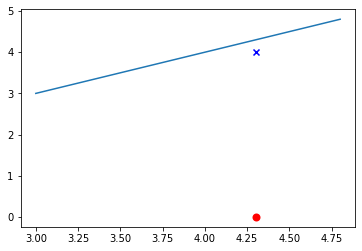

In [12]:
gam = LinearGAM(n_splines=10).fit(_x, _y)
gam.summary()

y_hat = gam.predict(_x)

for i in range(len(_x)):
    if _aux[i]:
        mark = "o" #compatible
    else:
        mark = "x" #no-compatible
    plt.scatter(_x[i], _y[i], marker=mark, color="blue")
    
plt.scatter(_x, y_hat, color='red', linewidth=2)
x = np.linspace(3.0, 4.8, 10)
plt.plot(x, x + 0, linestyle='solid')
plt.show()